## import modules

In [6]:
from compname import ChemFormula
from feature import CreateFeature, WrapperMethod
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

## Creating molar ratio

In [7]:
# loading csv
path = "./data/learning.csv"
df = pd.read_csv(path)
comp, sigma = df["X"].values, df["Y"].values

# creating moler ratio
path = "./data/atom.csv"
cn = ChemFormula(path)

# all, only F, not F
all_molratio = cn.get_molratio(comp)
f_molratio = cn.get_molratio(comp, obj_atoms=["F"])
cation_molratio = cn.get_molratio(comp, exc_atoms=["F"])

# creating molratio(dict)
dict_molratio = {
    "All" : all_molratio,
    "F" : f_molratio,
    "Cation" : cation_molratio
    }

## Creating features

In [8]:
# creating features of composition
cf = CreateFeature()

# get average features
dict_feature = cf.get_ave_features(dict_molratio)

# adding std features
dict_feature.update(cf.get_std_features(dict_molratio, exc=["F", "All"]))

# adding max features
dict_feature.update(cf.get_max_features(dict_molratio, exc=["F"]))

# adding min features
dict_feature.update(cf.get_min_features(dict_molratio, exc=["F"]))

# creating a new feature
dict_feature["Cation(Ave)/F(Ave)"] = dict_feature["Cation(Ave)"] / dict_feature["F(Ave)"]
dict_feature["All(Max)/F(Ave)"] = dict_feature["All(Max)"] / dict_feature["F(Ave)"]
dict_feature["All(Min)/F(Ave)"] = dict_feature["All(Min)"] / dict_feature["F(Ave)"]

# deleting a feature
del dict_feature["All(Max)"], dict_feature["All(Min)"], dict_feature["F(Ave)"]

# checking a features
print(dict_feature.keys())


dict_keys(['All(Ave)', 'Cation(Ave)', 'Cation(Std)', 'Cation(Max)', 'Cation(Min)', 'Cation(Ave)/F(Ave)', 'All(Max)/F(Ave)', 'All(Min)/F(Ave)'])


## Combining features

In [9]:
# creating dataframe of learnning
df = cf.get_df_learning(dict_feature, comp)

## Wrapper Method

In [10]:
# feature engneering using Wrapper Method
wm = WrapperMethod(X = df.values, y=sigma, feature_names=df.columns.values)
# Lasso
hyper_params = {
    'alpha':[0, 0.2, 0.4, 0.6, 0.8,1.0]
}
model = Lasso()
best_params_idx, cv_scores, train_scores, test_scores = wm.calc_forward(model, hyper_params)

100%|██████████| 146/146 [00:05<00:00, 25.27it/s]End



## Output of feature names

In [11]:
df.columns.values[best_params_idx]

array(['Cation(Ave)@polar', 'Cation(Ave)@ea', 'All(Min)/F(Ave)@MDS_2',
       'Cation(Max)@melt_p', 'Cation(Max)@MDS_1',
       'Cation(Ave)/F(Ave)@MDS_3', 'All(Min)/F(Ave)@Cp',
       'Cation(Max)@vale_e_num', 'All(Ave)@polar', 'Cation(Std)@boil_p',
       'Cation(Ave)@MDS_1', 'Cation(Ave)@melt_p', 'Cation(Ave)@MDS_2',
       'Cation(Std)@ion_rad', 'Cation(Std)@valence',
       'All(Max)/F(Ave)@polar', 'All(Max)/F(Ave)@MDS_1', 'Cation(Ave)@ie',
       'All(Min)/F(Ave)@polar', 'Cation(Std)@MDS_3',
       'Cation(Ave)/F(Ave)@Cp', 'Cation(Ave)@rd', 'Cation(Ave)@en',
       'Cation(Std)@at_num', 'Cation(Std)@at_wt', 'Cation(Max)@MDS_2',
       'Cation(Max)@polar', 'All(Ave)@ion_rad', 'Cation(Ave)@rco',
       'Cation(Min)@ea-ion_e', 'Cation(Ave)@MDS_3',
       'Cation(Ave)/F(Ave)@ea', 'Cation(Ave)/F(Ave)@MDS_2'], dtype=object)

## Learnning rate

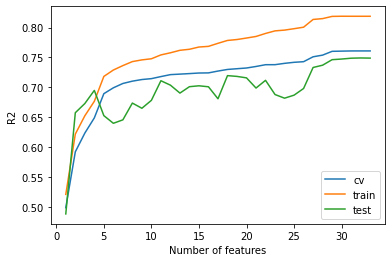

In [15]:
# plot
x = range(1,len(best_params_idx)+1)
plt.plot(x, cv_scores, label="cv")
plt.plot(x, train_scores, label="train")
plt.plot(x, test_scores, label="test")
plt.xlabel("Number of features [-]")
plt.ylabel("R2 [-]")
plt.legend(loc='lower right')
plt.show()